In [1]:
%%bash
gpustat
CUDA_VISIBLE_DEVICES="7"


hyperion  Mon Mar 25 14:14:13 2019
[0] TITAN X (Pascal) | 75'C,  51 % | 12175 / 12196 MB | s134843(12163M)
[1] TITAN X (Pascal) | 85'C,  57 % | 12177 / 12196 MB | s134843(12165M)
[2] TITAN X (Pascal) | 85'C,  73 % | 11361 / 12196 MB | s134843(11349M)
[3] TITAN X (Pascal) | 83'C,  39 % | 11195 / 12196 MB | s134843(11183M)
[4] TITAN X (Pascal) | 72'C,  16 % | 11725 / 12196 MB | jdram(11715M)
[5] TITAN X (Pascal) | 83'C,  18 % | 11725 / 12196 MB | jdram(11715M)
[6] TITAN X (Pascal) | 29'C,   0 % |     0 / 12196 MB |
[7] TITAN X (Pascal) | 30'C,   0 % |     0 / 12196 MB |


bash: module: line 1: syntax error: unexpected end of file
bash: error importing function definition for `module'


In [2]:
import os
import sys
#os.environ["CUDA_VISIBLE_DEVICES"]="7"


In [3]:
!ls /home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/fastai/
!ls /home/maghoi/course-v3/tools/
#!grep DataBunch /home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/fastai/*

basic_data.py	core.py		__init__.py  tabular	    vision
basics.py	data_block.py	launch.py    text	    widgets
basic_train.py	datasets.py	layers.py    torch_core.py
callback.py	distributed.py	metrics.py   train.py
callbacks	gen_doc		__pycache__  utils
collab.py	imports		script.py    version.py
build-site.sh  fastai-nbstripout  run-after-git-clone  trust-origin-git-config


In [4]:
from sklearn import metrics


In [5]:
import numpy as np
import pandas as pd
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
np.random.seed(12345)
import matplotlib.pyplot as plt
%matplotlib inline

from fastai.basic_data import *
from fastai.basic_train import *
from fastai.data_block import *
from fastai.metrics import *
from fastai.train import *
from fastai.utils import *
from fastai.core import *
from fastai.gen_doc import *

#from fastai import Learner,DataBunch

import torch
import torch.nn as nn
import torch.utils.data as tdatautils

import glob
import re


### Data loader
- X shape (complexes, amino positions, features) = (1464, 455, 9)
- Vector of complexes
- Vector of amino acids
- Dstack features with residues

In [6]:
ix_train = 1080
ix_val = 256
ix_test = 128
data_size=1464

ix_test = data_size - ix_test
ix_val = ix_test - ix_val
ix_train = ix_val - ix_train

print(data_size)
print(ix_test)
print(ix_val)
print(ix_train)

1464
1336
1080
0


In [7]:
#Start position 0
def data_generator(ix_train = 1080, ix_val = 256, ix_test = 128, data_size=1464):
        filelist = glob.glob("/scratch/maghoi/pMHC_data/features3/*.csv"); len(filelist)
        
        filelist_loaded = []
        ix_test = data_size - ix_test
        ix_val = ix_test - ix_val
        ix_train = ix_val - ix_train
        
        #Load data into dfs
        for i in range(0, len(filelist)):
            df = pd.read_csv(filelist[i])
            df = df.drop(["Unnamed: 0", "Num", "pACC", "CNb"], axis = 1)
            filelist_loaded.append(df)

        #Initialize empty df ordered by complexes and aminos
        dim1 = range(0, data_size)
        dim2 = filelist_loaded[0].index.values
        dim3 = filelist_loaded[0].columns
        x = np.zeros(shape = (len(dim1), len(dim2), len(dim3)))

        for i in range(0, data_size):
            x[i] = filelist_loaded[i]

        #Encode y fresh
        y = np.zeros(shape = (data_size), dtype="int64")

        counter_x = range(0, data_size)
        counter_y = range(len(y))

        for c_x, c_y in zip(counter_x, counter_y):
            r = re.compile(r'.*P1.*')
            if bool(r.match(filelist[c_x])):
                y[c_y] = 1
                
        X_train, y_train = x[0 : ix_val], y[0 : ix_val]
        X_val, y_val = x[ix_val : ix_test], y[ix_val : ix_test]
        X_test, y_test = x[ix_test : ], y[ix_test : ]
        return X_train, y_train, X_val, y_val, X_test, y_test


### Load data

In [8]:
%%time
X,y, X_val, y_val, X_test, y_test = data_generator()


CPU times: user 5.75 s, sys: 191 ms, total: 5.94 s
Wall time: 5.95 s


In [9]:
X.shape, y.shape, X_test.shape, y_test.shape, sum(y)

((1080, 405, 5), (1080,), (128, 405, 5), (128,), 180)

In [10]:
X[0]

array([[ 6.,  5., 18.,  2.,  2.],
       [13.,  5., 18.,  2.,  4.],
       [ 7.,  2.,  5.,  1.,  6.],
       [16.,  2.,  6.,  1.,  7.],
       ...,
       [10.,  2.,  5.,  0.,  9.],
       [16.,  2.,  5.,  1.,  7.],
       [18.,  2.,  5.,  0., 10.],
       [10.,  5., 18.,  2.,  6.]])

### 1.b Map the data to float/int as appropriate

Classification requires that targets are type INT

In [11]:
def to_torch_data(x,np_type,tch_type):
    return torch.from_numpy(x.astype(np_type)).to(tch_type)

X,X_val,X_test = map(lambda x: to_torch_data(x,float,torch.float32),(X,X_val,X_test))
y,y_val,y_test = map(lambda x: to_torch_data(x,int,torch.int64),(y,y_val,y_test))

In [12]:
train_ds = tdatautils.TensorDataset(X,y)
valid_ds = tdatautils.TensorDataset(X_val,y_val)
test_ds = tdatautils.TensorDataset(X_test,y_test)

#Load data
batch_size = 1
my_data_bunch = DataBunch.create(train_ds,valid_ds,test_ds,bs=batch_size)

In [13]:
print(X)

tensor([[[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]],

        [[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]],

        [[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]],

        ...,

        [[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]],

        [[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18

In [16]:
print(y)

tensor([0, 1, 1,  ..., 0, 0, 0])


## 2. Model

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [18]:
# Accuracy metrics
#acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2, beta = 1)

In [19]:
2+4

6

### Index error causes corrupt CUDA context -> Hard-reset required

In [ ]:
len(valid_ds.tensors[1])

In [ ]:
256/64

In [ ]:
batch_size = 3
my_data_bunch = DataBunch.create(train_ds,valid_ds,test_ds,bs=batch_size)
criterion = nn.NLLLoss()

class Model(nn.Module):
    def __init__(self, num_classes = 2):
        super(Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 405, out_channels = 1, kernel_size = 1)
        self.last = nn.Linear(5, num_classes)
        self.log_softmax_layer = nn.LogSoftmax(dim = 2)
        

    def forward(self, x):
        #input_size = x.shape[0]
        input_size = batch_size
        
        print("\nInput", x.shape)
        x = self.conv1(x)
        print("After conv:", x.shape)
        x = self.last(x)
        print("Before softmax", x)
        x = self.log_softmax_layer(x)
        x = x.view(input_size, 2)
        
        print("End:", x.shape)
        print("End:", x)
        return x

#print(net)  
#print( 'trainable params: {}'.format(count_model_params(net)) )
net = Model().cuda()

my_learner = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion, metrics=accuracy_thresh)
my_learner.fit_one_cycle(1, 5e-02)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


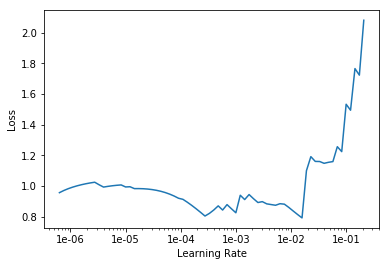

In [270]:
my_learner.lr_find()
my_learner.recorder.plot()


In [271]:
my_learner.fit_one_cycle(5, 1e-03)



Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[1.3125, 2.0276]],

        [[1.3125, 2.0276]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-1.1133, -0.3982],
        [-1.1133, -0.3982]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[1.2894, 1.9050]],

        [[1.2894, 1.9050]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-1.0476, -0.4320],
        [-1.0476, -0.4320]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[1.2703, 1.8033]],

        [[1.2703, 1.8033]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.9948, -0.4617],
        [-0.9948, -0.4617]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Be


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7768, -0.7621]],

        [[ 0.7768, -0.7621]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1944, -1.7333],
        [-0.1944, -1.7333]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7605, -0.8453]],

        [[ 0.7605, -0.8453]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7887],
        [-0.1829, -1.7887]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7443, -0.9283]],

        [[ 0.7443, -0.9283]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1721, -1.8447],
        [-0.1721, -1.8447]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6003, -1.6570]],

        [[ 0.6003, -1.6570]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0995, -2.3568],
        [-0.0995, -2.3568]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6029, -1.6433]],

        [[ 0.6029, -1.6433]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1006, -2.3468],
        [-0.1006, -2.3468]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6094, -1.6098]],

        [[ 0.6094, -1.6098]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1032, -2.3223],
        [-0.1032, -2.3223]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

End: torch.Size([2, 2])
End: tensor([[-0.2121, -1.6551],
        [-0.2121, -1.6551]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8016, -0.6259]],

        [[ 0.8016, -0.6259]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2150, -1.6426],
        [-0.2150, -1.6426]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8041, -0.6134]],

        [[ 0.8041, -0.6134]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2170, -1.6345],
        [-0.2170, -1.6345]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8052, -0.6075]],

        [[ 0.8052, -0.6075]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2179, -1.6307]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7736, -0.7685]],

        [[ 0.7736, -0.7685]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1939, -1.7359],
        [-0.1939, -1.7359]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7708, -0.7824]],

        [[ 0.7708, -0.7824]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1919, -1.7452],
        [-0.1919, -1.7452]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7667, -0.8035]],

        [[ 0.7667, -0.8035]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1890, -1.7591],
        [-0.1890, -1.7591]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8848, -0.2032]],

        [[ 0.8848, -0.2032]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2903, -1.3783],
        [-0.2903, -1.3783]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8920, -0.1668]],

        [[ 0.8920, -0.1668]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2978, -1.3566],
        [-0.2978, -1.3566]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8957, -0.1478]],

        [[ 0.8957, -0.1478]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.3018, -1.3452],
        [-0.3018, -1.3452]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

Before softmax tensor([[[ 0.8948, -0.1533]],

        [[ 0.8948, -0.1533]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.3006, -1.3486],
        [-0.3006, -1.3486]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8797, -0.2298]],

        [[ 0.8797, -0.2298]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2850, -1.3944],
        [-0.2850, -1.3944]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8772, -0.2422]],

        [[ 0.8772, -0.2422]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2825, -1.4020],
        [-0.2825, -1.4020]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8710, -0.2736]],

        [


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7121, -1.0722]],

        [[ 0.7121, -1.0722]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1552, -1.9395],
        [-0.1552, -1.9395]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7125, -1.0701]],

        [[ 0.7125, -1.0701]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1555, -1.9380],
        [-0.1555, -1.9380]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7203, -1.0303]],

        [[ 0.7203, -1.0303]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1601, -1.9108],
        [-0.1601, -1.9108]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

Before softmax tensor([[[ 0.5791, -1.7369]],

        [[ 0.5791, -1.7369]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0941, -2.4101],
        [-0.0941, -2.4101]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5928, -1.6677]],

        [[ 0.5928, -1.6677]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0992, -2.3596],
        [-0.0992, -2.3596]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6170, -1.5454]],

        [[ 0.6170, -1.5454]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1089, -2.2713],
        [-0.1089, -2.2713]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6368, -1.4452]],

        [

End: tensor([[-0.2011, -1.7027],
        [-0.2011, -1.7027]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7371, -0.9481]],

        [[ 0.7371, -0.9481]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1701, -1.8553],
        [-0.1701, -1.8553]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6877, -1.1908]],

        [[ 0.6877, -1.1908]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1422, -2.0207],
        [-0.1422, -2.0207]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6366, -1.4411]],

        [[ 0.6366, -1.4411]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1180, -2.1957],
        [-0.1180, -2.1

End: tensor([[-0.0792, -2.5751],
        [-0.0792, -2.5751]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5803, -1.6487]],

        [[ 0.5803, -1.6487]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1022, -2.3312],
        [-0.1022, -2.3312]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6623, -1.2503]],

        [[ 0.6623, -1.2503]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1378, -2.0504],
        [-0.1378, -2.0504]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7555, -0.8003]],

        [[ 0.7555, -0.8003]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1915, -1.7473],
        [-0.1915, -1.7

End: torch.Size([2, 2])
End: tensor([[-0.0720, -2.6663],
        [-0.0720, -2.6663]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4591, -2.2275]],

        [[ 0.4591, -2.2275]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0659, -2.7525],
        [-0.0659, -2.7525]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4314, -2.3534]],

        [[ 0.4314, -2.3534]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0599, -2.8447],
        [-0.0599, -2.8447]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4026, -2.4846]],

        [[ 0.4026, -2.4846]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0542, -2.9415]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7087, -1.0154]],

        [[ 0.7087, -1.0154]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1641, -1.8882],
        [-0.1641, -1.8882]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7172, -0.9763]],

        [[ 0.7172, -0.9763]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1688, -1.8623],
        [-0.1688, -1.8623]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7482, -0.8339]],

        [[ 0.7482, -0.8339]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1869, -1.7690],
        [-0.1869, -1.7690]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5226, -1.8473]],

        [[ 0.5226, -1.8473]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0894, -2.4593],
        [-0.0894, -2.4593]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4689, -2.0888]],

        [[ 0.4689, -2.0888]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0746, -2.6323],
        [-0.0746, -2.6323]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4548, -2.1501]],

        [[ 0.4548, -2.1501]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0713, -2.6762],
        [-0.0713, -2.6762]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor

Before softmax tensor([[[ 0.2345, -2.9752]],

        [[ 0.2345, -2.9752]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0396, -3.2493],
        [-0.0396, -3.2493]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2457, -2.9167]],

        [[ 0.2457, -2.9167]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0415, -3.2038],
        [-0.0415, -3.2038]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2521, -2.8801]],

        [[ 0.2521, -2.8801]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0427, -3.1749],
        [-0.0427, -3.1749]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2542, -2.8638]],

        [


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2810, -2.6851]],

        [[ 0.2810, -2.6851]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0502, -3.0163],
        [-0.0502, -3.0163]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2630, -2.7540]],

        [[ 0.2630, -2.7540]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0478, -3.0648],
        [-0.0478, -3.0648]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2419, -2.8369]],

        [[ 0.2419, -2.8369]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0450, -3.1238],
        [-0.0450, -3.1238]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8336, -0.4599]],

        [[ 0.8336, -0.4599]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2424, -1.5359],
        [-0.2424, -1.5359]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8168, -0.5252]],

        [[ 0.8168, -0.5252]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2322, -1.5742],
        [-0.2322, -1.5742]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7768, -0.6804]],

        [[ 0.7768, -0.6804]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2093, -1.6666],
        [-0.2093, -1.6666]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2780, -2.4344]],

        [[ 0.2780, -2.4344]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0643, -2.7767],
        [-0.0643, -2.7767]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.0818, -3.0957]],

        [[ 0.0818, -3.0957]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0408, -3.2183],
        [-0.0408, -3.2183]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.0999, -3.7006]],

        [[-0.0999, -3.7006]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0269, -3.6276],
        [-0.0269, -3.6276]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5217, -0.8677]],

        [[ 0.5217, -0.8677]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2225, -1.6119],
        [-0.2225, -1.6119]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6492, -0.4377]],

        [[ 0.6492, -0.4377]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2906, -1.3775],
        [-0.2906, -1.3775]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[0.8531, 0.2422]],

        [[0.8531, 0.2422]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.4336, -1.0445],
        [-0.4336, -1.0445]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1

Before softmax tensor([[[-0.2894, -3.3866]],

        [[-0.2894, -3.3866]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0442, -3.1414],
        [-0.0442, -3.1414]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.2773, -3.3347]],

        [[-0.2773, -3.3347]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0459, -3.1034],
        [-0.0459, -3.1034]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.2716, -3.3070]],

        [[-0.2716, -3.3070]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0469, -3.0823],
        [-0.0469, -3.0823]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.2718, -3.3010]],

        [


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646],
        [-0.0651, -2.7646]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646],
        [-0.0651, -2.7646]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646],
        [-0.0651, -2.7646]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646],
        [-0.0651, -2.7646]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646],
        [-0.0651, -2.7646]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646],
        [-0.0651, -2.7646]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646],
        [-0.0651, -2.7646]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646],
        [-0.0651, -2.7646]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646],
        [-0.0651, -2.7646]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646]

Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646],
        [-0.0651, -2.7646]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646],
        [-0.0651, -2.7646]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646],
        [-0.0651, -2.7646]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1482, -2.8478]],

        [[-0.1482, -2.8478]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.0651, -2.7646],
        [-0.0651, -2.7646]], device='cuda:0')

Input torch.Size


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2903, -1.4136]],

        [[ 0.2903, -1.4136]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1672, -1.8710],
        [-0.1672, -1.8710]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3217, -1.3100]],

        [[ 0.3217, -1.3100]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1787, -1.8103],
        [-0.1787, -1.8103]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3288, -1.2865]],

        [[ 0.3288, -1.2865]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1813, -1.7967],
        [-0.1813, -1.7967]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

End: torch.Size([2, 2])
End: tensor([[-0.1448, -2.0041],
        [-0.1448, -2.0041]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3745, -1.1239]],

        [[ 0.3745, -1.1239]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2017, -1.7001],
        [-0.2017, -1.7001]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5621, -0.5324]],

        [[ 0.5621, -0.5324]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2887, -1.3832],
        [-0.2887, -1.3832]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6932, -0.1269]],

        [[ 0.6932, -0.1269]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.3649, -1.1850]

Before softmax tensor([[[ 0.2329, -1.4264]],

        [[ 0.2329, -1.4264]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1742, -1.8335],
        [-0.1742, -1.8335]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2985, -1.1980]],

        [[ 0.2985, -1.1980]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2021, -1.6985],
        [-0.2021, -1.6985]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3367, -1.0673]],

        [[ 0.3367, -1.0673]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2196, -1.6237],
        [-0.2196, -1.6237]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4012, -0.8444]],

        [


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1416, -2.8453]],

        [[-0.1416, -2.8453]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0648, -2.7685],
        [-0.0648, -2.7685]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1533, -2.8844]],

        [[-0.1533, -2.8844]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0631, -2.7942],
        [-0.0631, -2.7942]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.1694, -2.9411]],

        [[-0.1694, -2.9411]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0607, -2.8324],
        [-0.0607, -2.8324]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

End: tensor([[-0.0662, -2.7475],
        [-0.0662, -2.7475]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.0681, -2.5427]],

        [[-0.0681, -2.5427]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0808, -2.5554],
        [-0.0808, -2.5554]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[-0.0128, -2.3333]],

        [[-0.0128, -2.3333]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0937, -2.4142],
        [-0.0937, -2.4142]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.0759, -1.9996]],

        [[ 0.0759, -1.9996]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1182, -2.1937],
        [-0.1182, -2.1


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.0105, -2.4617]],

        [[ 0.0105, -2.4617]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0810, -2.5532],
        [-0.0810, -2.5532]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.0421, -2.2967]],

        [[ 0.0421, -2.2967]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0921, -2.4309],
        [-0.0921, -2.4309]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.0968, -2.0227]],

        [[ 0.0968, -2.0227]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1134, -2.2329],
        [-0.1134, -2.2329]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.0961, -2.9688]],

        [[ 0.0961, -2.9688]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0456, -3.1105],
        [-0.0456, -3.1105]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.0852, -3.0475]],

        [[ 0.0852, -3.0475]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0427, -3.1753],
        [-0.0427, -3.1753]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.0820, -2.9960]],

        [[ 0.0820, -2.9960]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0450, -3.1230],
        [-0.0450, -3.1230]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2265, -1.4963]],

        [[ 0.2265, -1.4963]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1643, -1.8871],
        [-0.1643, -1.8871]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2358, -1.5970]],

        [[ 0.2358, -1.5970]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1484, -1.9812],
        [-0.1484, -1.9812]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2460, -1.7103]],

        [[ 0.2460, -1.7103]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1322, -2.0886],
        [-0.1322, -2.0886]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2658, -0.3218]],

        [[ 0.2658, -0.3218]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.4419, -1.0295],
        [-0.4419, -1.0295]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2760, -0.3756]],

        [[ 0.2760, -0.3756]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.4195, -1.0711],
        [-0.4195, -1.0711]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2934, -0.4776]],

        [[ 0.2934, -0.4776]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.3802, -1.1511],
        [-0.3802, -1.1511]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor

Before softmax tensor([[[ 0.5688, -2.0114]],

        [[ 0.5688, -2.0114]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0730, -2.6532],
        [-0.0730, -2.6532]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5507, -1.9337]],

        [[ 0.5507, -1.9337]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0801, -2.5644],
        [-0.0801, -2.5644]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5194, -1.8004]],

        [[ 0.5194, -1.8004]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0938, -2.4135],
        [-0.0938, -2.4135]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4968, -1.7014]],

        [

Before softmax tensor([[[ 0.6247, -1.7199]],

        [[ 0.6247, -1.7199]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0916, -2.4362],
        [-0.0916, -2.4362]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5648, -1.5506]],

        [[ 0.5648, -1.5506]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1139, -2.2292],
        [-0.1139, -2.2292]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5200, -1.4216]],

        [[ 0.5200, -1.4216]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1341, -2.0757],
        [-0.1341, -2.0757]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4886, -1.3285]],

        [

After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3921, -0.9782]],

        [[ 0.3921, -0.9782]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2264, -1.5967],
        [-0.2264, -1.5967]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3396, -0.8457]],

        [[ 0.3396, -0.8457]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2667, -1.4520],
        [-0.2667, -1.4520]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3065, -0.7606]],

        [[ 0.3065, -0.7606]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2957, -1.3627],
        [-0.2957, -1.3627]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7088, -1.6879]],

        [[ 0.7088, -1.6879]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0871, -2.4838],
        [-0.0871, -2.4838]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7331, -1.7446]],

        [[ 0.7331, -1.7446]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0806, -2.5584],
        [-0.0806, -2.5584]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7582, -1.8019]],

        [[ 0.7582, -1.8019]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0745, -2.6345],
        [-0.0745, -2.6345]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3660, -0.9848]],

        [[ 0.3660, -0.9848]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2303, -1.5811],
        [-0.2303, -1.5811]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3348, -0.9282]],

        [[ 0.3348, -0.9282]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2490, -1.5121],
        [-0.2490, -1.5121]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.2935, -0.8537]],

        [[ 0.2935, -0.8537]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2757, -1.4230],
        [-0.2757, -1.4230]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor

Before softmax tensor([[[ 0.5067, -1.2322]],

        [[ 0.5067, -1.2322]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1619, -1.9008],
        [-0.1619, -1.9008]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5266, -1.2683]],

        [[ 0.5266, -1.2683]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1537, -1.9485],
        [-0.1537, -1.9485]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5510, -1.3123]],

        [[ 0.5510, -1.3123]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1443, -2.0075],
        [-0.1443, -2.0075]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5789, -1.3624]],

        [


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6845, -1.5435]],

        [[ 0.6845, -1.5435]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1023, -2.3303],
        [-0.1023, -2.3303]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6703, -1.5170]],

        [[ 0.6703, -1.5170]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1064, -2.2936],
        [-0.1064, -2.2936]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6635, -1.5041]],

        [[ 0.6635, -1.5041]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1084, -2.2760],
        [-0.1084, -2.2760]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6005, -1.3408]],

        [[ 0.6005, -1.3408]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1341, -2.0754],
        [-0.1341, -2.0754]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5889, -1.3141]],

        [[ 0.5889, -1.3141]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1390, -2.0420],
        [-0.1390, -2.0420]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5857, -1.3033]],

        [[ 0.5857, -1.3033]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1408, -2.0299],
        [-0.1408, -2.0299]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4003, -0.8944]],

        [[ 0.4003, -0.8944]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2421, -1.5368],
        [-0.2421, -1.5368]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3936, -0.8800]],

        [[ 0.3936, -0.8800]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2467, -1.5203],
        [-0.2467, -1.5203]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3508, -0.8041]],

        [[ 0.3508, -0.8041]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2739, -1.4288],
        [-0.2739, -1.4288]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5568, -1.1213]],

        [[ 0.5568, -1.1213]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1712, -1.8494],
        [-0.1712, -1.8494]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5555, -1.1191]],

        [[ 0.5555, -1.1191]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1717, -1.8464],
        [-0.1717, -1.8464]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5376, -1.0903]],

        [[ 0.5376, -1.0903]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1793, -1.8072],
        [-0.1793, -1.8072]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500],
        [-0.2386, -1.5500]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500],
        [-0.2386, -1.5500]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500],
        [-0.2386, -1.5500]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500],
        [-0.2386, -1.5500]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500],
        [-0.2386, -1.5500]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500],
        [-0.2386, -1.5500]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500],
        [-0.2386, -1.5500]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500],
        [-0.2386, -1.5500]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500],
        [-0.2386, -1.5500]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500]

End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500],
        [-0.2386, -1.5500]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500],
        [-0.2386, -1.5500]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500],
        [-0.2386, -1.5500]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],

        [[ 0.4189, -0.8925]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2386, -1.5500],
        [-0.2386, -1.5500]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4189, -0.8925]],




Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3233, -0.7364]],

        [[ 0.3233, -0.7364]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2976, -1.3573],
        [-0.2976, -1.3573]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3151, -0.7229]],

        [[ 0.3151, -0.7229]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.3032, -1.3411],
        [-0.3032, -1.3411]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3198, -0.7305]],

        [[ 0.3198, -0.7305]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.3000, -1.3502],
        [-0.3000, -1.3502]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7149, -1.3821]],

        [[ 0.7149, -1.3821]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1159, -2.2128],
        [-0.1159, -2.2128]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7078, -1.3702]],

        [[ 0.7078, -1.3702]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1179, -2.1960],
        [-0.1179, -2.1960]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7071, -1.3687]],

        [[ 0.7071, -1.3687]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1182, -2.1940],
        [-0.1182, -2.1940]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3744, -0.8142]],

        [[ 0.3744, -0.8142]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2659, -1.4546],
        [-0.2659, -1.4546]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3654, -0.7989]],

        [[ 0.3654, -0.7989]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2717, -1.4360],
        [-0.2717, -1.4360]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3681, -0.8016]],

        [[ 0.3681, -0.8016]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2704, -1.4401],
        [-0.2704, -1.4401]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3194, -0.7115]],

        [[ 0.3194, -0.7115]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.3050, -1.3359],
        [-0.3050, -1.3359]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3380, -0.7401]],

        [[ 0.3380, -0.7401]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2928, -1.3710],
        [-0.2928, -1.3710]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.3438, -0.7489]],

        [[ 0.3438, -0.7489]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2892, -1.3819],
        [-0.2892, -1.3819]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor

Before softmax tensor([[[ 0.6077, -1.1577]],

        [[ 0.6077, -1.1577]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1580, -1.9234],
        [-0.1580, -1.9234]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6243, -1.1835]],

        [[ 0.6243, -1.1835]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1519, -1.9597],
        [-0.1519, -1.9597]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6232, -1.1814]],

        [[ 0.6232, -1.1814]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1523, -1.9569],
        [-0.1523, -1.9569]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6283, -1.1891]],

        [


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7529, -1.3773]],

        [[ 0.7529, -1.3773]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1123, -2.2425],
        [-0.1123, -2.2425]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7595, -1.3878]],

        [[ 0.7595, -1.3878]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1105, -2.2577],
        [-0.1105, -2.2577]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7483, -1.3691]],

        [[ 0.7483, -1.3691]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1136, -2.2311],
        [-0.1136, -2.2311]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6241, -1.1495]],

        [[ 0.6241, -1.1495]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1568, -1.9303],
        [-0.1568, -1.9303]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5877, -1.0881]],

        [[ 0.5877, -1.0881]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1716, -1.8473],
        [-0.1716, -1.8473]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5628, -1.0453]],

        [[ 0.5628, -1.0453]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1825, -1.7906],
        [-0.1825, -1.7906]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

End: torch.Size([2, 2])
End: tensor([[-0.2597, -1.4751],
        [-0.2597, -1.4751]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4556, -0.8348]],

        [[ 0.4556, -0.8348]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2431, -1.5335],
        [-0.2431, -1.5335]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4906, -0.8853]],

        [[ 0.4906, -0.8853]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2252, -1.6011],
        [-0.2252, -1.6011]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5288, -0.9404]],

        [[ 0.5288, -0.9404]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2071, -1.6763]

After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7644, -1.2792]],

        [[ 0.7644, -1.2792]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1218, -2.1654],
        [-0.1218, -2.1654]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7567, -1.2683]],

        [[ 0.7567, -1.2683]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1240, -2.1490],
        [-0.1240, -2.1490]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7343, -1.2368]],

        [[ 0.7343, -1.2368]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1304, -2.1015],
        [-0.1304, -2.1015]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5871, -1.0154]],

        [[ 0.5871, -1.0154]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1835, -1.7860],
        [-0.1835, -1.7860]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5635, -0.9831]],

        [[ 0.5635, -0.9831]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1931, -1.7397],
        [-0.1931, -1.7397]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5499, -0.9640]],

        [[ 0.5499, -0.9640]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1989, -1.7128],
        [-0.1989, -1.7128]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

Before softmax tensor([[[ 0.7670, -1.2421]],

        [[ 0.7670, -1.2421]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1258, -2.1350],
        [-0.1258, -2.1350]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7575, -1.2292]],

        [[ 0.7575, -1.2292]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1285, -2.1153],
        [-0.1285, -2.1153]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7160, -1.1718]],

        [[ 0.7160, -1.1718]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1410, -2.0288],
        [-0.1410, -2.0288]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6852, -1.1290]],

        [

Before softmax tensor([[[ 0.7309, -1.1717]],

        [[ 0.7309, -1.1717]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1390, -2.0417],
        [-0.1390, -2.0417]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7326, -1.1736]],

        [[ 0.7326, -1.1736]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1386, -2.0448],
        [-0.1386, -2.0448]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7389, -1.1817]],

        [[ 0.7389, -1.1817]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1367, -2.0573],
        [-0.1367, -2.0573]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7492, -1.1950]],

        [

After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.9182, -1.4185]],

        [[ 0.9182, -1.4185]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0923, -2.4290],
        [-0.0923, -2.4290]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.9295, -1.4341]],

        [[ 0.9295, -1.4341]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0899, -2.4535],
        [-0.0899, -2.4535]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.9239, -1.4258]],

        [[ 0.9239, -1.4258]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.0911, -2.4409],
        [-0.0911, -2.4409]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor

End: torch.Size([2, 2])
End: tensor([[-0.2116, -1.6571],
        [-0.2116, -1.6571]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5611, -0.8968]],

        [[ 0.5611, -0.8968]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2092, -1.6671],
        [-0.2092, -1.6671]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5725, -0.9105]],

        [[ 0.5725, -0.9105]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2045, -1.6875],
        [-0.2045, -1.6875]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5887, -0.9302]],

        [[ 0.5887, -0.9302]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1980, -1.7168]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5243, -0.8416]],

        [[ 0.5243, -0.8416]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2273, -1.5931],
        [-0.2273, -1.5931]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5200, -0.8362]],

        [[ 0.5200, -0.8362]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2292, -1.5854],
        [-0.2292, -1.5854]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5069, -0.8199]],

        [[ 0.5069, -0.8199]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2353, -1.5621],
        [-0.2353, -1.5621]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

End: tensor([[-0.1463, -1.9943],
        [-0.1463, -1.9943]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7473, -1.1158]],

        [[ 0.7473, -1.1158]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1443, -2.0074],
        [-0.1443, -2.0074]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7577, -1.1284]],

        [[ 0.7577, -1.1284]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1412, -2.0273],
        [-0.1412, -2.0273]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7711, -1.1447]],

        [[ 0.7711, -1.1447]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1373, -2.0532],
        [-0.1373, -2.0


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8280, -1.2109]],

        [[ 0.8280, -1.2109]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1224, -2.1613],
        [-0.1224, -2.1613]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8201, -1.2009]],

        [[ 0.8201, -1.2009]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1244, -2.1455],
        [-0.1244, -2.1455]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8168, -1.1967]],

        [[ 0.8168, -1.1967]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1253, -2.1389],
        [-0.1253, -2.1389]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5555, -0.8516]],

        [[ 0.5555, -0.8516]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2190, -1.6261],
        [-0.2190, -1.6261]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5903, -0.8907]],

        [[ 0.5903, -0.8907]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2049, -1.6859],
        [-0.2049, -1.6859]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6265, -0.9312]],

        [[ 0.6265, -0.9312]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1911, -1.7489],
        [-0.1911, -1.7489]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor

End: tensor([[-0.2284, -1.5888],
        [-0.2284, -1.5888]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5388, -0.8352]],

        [[ 0.5388, -0.8352]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2256, -1.5996],
        [-0.2256, -1.5996]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5365, -0.8325]],

        [[ 0.5365, -0.8325]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2266, -1.5957],
        [-0.2266, -1.5957]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5401, -0.8361]],

        [[ 0.5401, -0.8361]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2252, -1.6014],
        [-0.2252, -1.6


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6097, -0.9078]],

        [[ 0.6097, -0.9078]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1982, -1.7157],
        [-0.1982, -1.7157]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6146, -0.9132]],

        [[ 0.6146, -0.9132]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1964, -1.7242],
        [-0.1964, -1.7242]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6236, -0.9230]],

        [[ 0.6236, -0.9230]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1931, -1.7397],
        [-0.1931, -1.7397]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5447, -0.8241]],

        [[ 0.5447, -0.8241]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2267, -1.5955],
        [-0.2267, -1.5955]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5447, -0.8241]],

        [[ 0.5447, -0.8241]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2267, -1.5955],
        [-0.2267, -1.5955]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5447, -0.8241]],

        [[ 0.5447, -0.8241]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2267, -1.5955],
        [-0.2267, -1.5955]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5447, -0.8241]],

        [[ 0.5447, -0.8241]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2267, -1.5955]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5447, -0.8241]],

        [[ 0.5447, -0.8241]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2267, -1.5955],
        [-0.2267, -1.5955]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5447, -0.8241]],

        [[ 0.5447, -0.8241]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2267, -1.5955],
        [-0.2267, -1.5955]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5447, -0.8241]],

        [[ 0.5447, -0.8241]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2267, -1.5955],
        [-0.2267, -1.5955]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5447, -0.8241]],

        [[ 0.5447, -0.8241]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2267, -1.5955]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5447, -0.8241]],

        [[ 0.5447, -0.8241]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2267, -1.5955],
        [-0.2267, -1.5955]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5447, -0.8241]],

        [[ 0.5447, -0.8241]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2267, -1.5955],
        [-0.2267, -1.5955]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5447, -0.8241]],

        [[ 0.5447, -0.8241]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2267, -1.5955],
        [-0.2267, -1.5955]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5447, -0.8241]],

        [[ 0.5447, -0.8241]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.2267, -1.5955]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4963, -0.7652]],

        [[ 0.4963, -0.7652]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2494, -1.5109],
        [-0.2494, -1.5109]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4927, -0.7607]],

        [[ 0.4927, -0.7607]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2512, -1.5046],
        [-0.2512, -1.5046]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4949, -0.7623]],

        [[ 0.4949, -0.7623]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2503, -1.5075],
        [-0.2503, -1.5075]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7173, -0.9940]],

        [[ 0.7173, -0.9940]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1660, -1.8774],
        [-0.1660, -1.8774]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7213, -0.9983]],

        [[ 0.7213, -0.9983]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1648, -1.8843],
        [-0.1648, -1.8843]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7285, -1.0060]],

        [[ 0.7285, -1.0060]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1625, -1.8970],
        [-0.1625, -1.8970]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor

Before softmax tensor([[[ 0.8477, -1.1315]],

        [[ 0.8477, -1.1315]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1294, -2.1087],
        [-0.1294, -2.1087]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8454, -1.1288]],

        [[ 0.8454, -1.1288]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1300, -2.1042],
        [-0.1300, -2.1042]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8462, -1.1295]],

        [[ 0.8462, -1.1295]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1299, -2.1056],
        [-0.1299, -2.1056]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8497, -1.1333]],

        [


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7752, -1.0202]],

        [[ 0.7752, -1.0202]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1536, -1.9491],
        [-0.1536, -1.9491]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7794, -1.0245]],

        [[ 0.7794, -1.0245]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1524, -1.9563],
        [-0.1524, -1.9563]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7659, -1.0094]],

        [[ 0.7659, -1.0094]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1565, -1.9318],
        [-0.1565, -1.9318]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5458, -0.7516]],

        [[ 0.5458, -0.7516]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2416, -1.5390],
        [-0.2416, -1.5390]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5529, -0.7590]],

        [[ 0.5529, -0.7590]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2385, -1.5503],
        [-0.2385, -1.5503]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5630, -0.7696]],

        [[ 0.5630, -0.7696]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2341, -1.5667],
        [-0.2341, -1.5667]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

Before softmax tensor([[[ 0.8170, -1.0385]],

        [[ 0.8170, -1.0385]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1453, -2.0008],
        [-0.1453, -2.0008]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8173, -1.0388]],

        [[ 0.8173, -1.0388]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1452, -2.0014],
        [-0.1452, -2.0014]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8201, -1.0416]],

        [[ 0.8201, -1.0416]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1445, -2.0062],
        [-0.1445, -2.0062]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8249, -1.0467]],

        [

Before softmax tensor([[[ 0.8351, -1.0556]],

        [[ 0.8351, -1.0556]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1406, -2.0313],
        [-0.1406, -2.0313]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8282, -1.0480]],

        [[ 0.8282, -1.0480]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1425, -2.0187],
        [-0.1425, -2.0187]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8241, -1.0435]],

        [[ 0.8241, -1.0435]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1437, -2.0113],
        [-0.1437, -2.0113]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.8144, -1.0329]],

        [

End: torch.Size([2, 2])
End: tensor([[-0.2179, -1.6306],
        [-0.2179, -1.6306]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5856, -0.7868]],

        [[ 0.5856, -0.7868]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2259, -1.5984],
        [-0.2259, -1.5984]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5709, -0.7713]],

        [[ 0.5709, -0.7713]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2321, -1.5743],
        [-0.2321, -1.5743]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5605, -0.7603]],

        [[ 0.5605, -0.7603]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2366, -1.5575]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4402, -0.6328]],

        [[ 0.4402, -0.6328]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2941, -1.3671],
        [-0.2941, -1.3671]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4502, -0.6431]],

        [[ 0.4502, -0.6431]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2890, -1.3823],
        [-0.2890, -1.3823]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.4626, -0.6559]],

        [[ 0.4626, -0.6559]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2827, -1.4013],
        [-0.2827, -1.4013]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6387, -0.8394]],

        [[ 0.6387, -0.8394]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2054, -1.6835],
        [-0.2054, -1.6835]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6410, -0.8418]],

        [[ 0.6410, -0.8418]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2046, -1.6874],
        [-0.2046, -1.6874]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6455, -0.8464]],

        [[ 0.6455, -0.8464]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2029, -1.6948],
        [-0.2029, -1.6948]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7819, -0.9890]],

        [[ 0.7819, -0.9890]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1572, -1.9281],
        [-0.1572, -1.9281]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7812, -0.9881]],

        [[ 0.7812, -0.9881]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1574, -1.9267],
        [-0.1574, -1.9267]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7823, -0.9892]],

        [[ 0.7823, -0.9892]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1571, -1.9286],
        [-0.1571, -1.9286]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7691, -0.9711]],

        [[ 0.7691, -0.9711]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1617, -1.9018],
        [-0.1617, -1.9018]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7582, -0.9587]],

        [[ 0.7582, -0.9587]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1652, -1.8821],
        [-0.1652, -1.8821]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7499, -0.9492]],

        [[ 0.7499, -0.9492]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1679, -1.8670],
        [-0.1679, -1.8670]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5872, -0.7644]],

        [[ 0.5872, -0.7644]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2302, -1.5818],
        [-0.2302, -1.5818]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5883, -0.7653]],

        [[ 0.5883, -0.7653]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2298, -1.5834],
        [-0.2298, -1.5834]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.5818, -0.7581]],

        [[ 0.5818, -0.7581]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2326, -1.5725],
        [-0.2326, -1.5725]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6786, -0.8613]],

        [[ 0.6786, -0.8613]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1942, -1.7342],
        [-0.1942, -1.7342]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6820, -0.8650]],

        [[ 0.6820, -0.8650]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1930, -1.7400],
        [-0.1930, -1.7400]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6867, -0.8701]],

        [[ 0.6867, -0.8701]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1913, -1.7481],
        [-0.1913, -1.7481]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6437, -0.8207]],

        [[ 0.6437, -0.8207]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2080, -1.6724],
        [-0.2080, -1.6724]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6458, -0.8231]],

        [[ 0.6458, -0.8231]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2072, -1.6760],
        [-0.2072, -1.6760]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6453, -0.8225]],

        [[ 0.6453, -0.8225]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.2074, -1.6752],
        [-0.2074, -1.6752]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7496, -0.9403]],

        [[ 0.7496, -0.9403]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1694, -1.8592],
        [-0.1694, -1.8592]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7481, -0.9384]],

        [[ 0.7481, -0.9384]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1699, -1.8564],
        [-0.1699, -1.8564]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7479, -0.9381]],

        [[ 0.7479, -0.9381]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1700, -1.8559],
        [-0.1700, -1.8559]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

End: tensor([[-0.1785, -1.8113],
        [-0.1785, -1.8113]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7257, -0.9098]],

        [[ 0.7257, -0.9098]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1780, -1.8135],
        [-0.1780, -1.8135]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7247, -0.9086]],

        [[ 0.7247, -0.9086]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1784, -1.8116],
        [-0.1784, -1.8116]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7248, -0.9087]],

        [[ 0.7248, -0.9087]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1784, -1.8118],
        [-0.1784, -1.8


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7009, -0.8776]],

        [[ 0.7009, -0.8776]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1875, -1.7661],
        [-0.1875, -1.7661]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7012, -0.8780]],

        [[ 0.7012, -0.8780]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1874, -1.7666],
        [-0.1874, -1.7666]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7024, -0.8794]],

        [[ 0.7024, -0.8794]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1870, -1.7688],
        [-0.1870, -1.7688]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7614, -0.9521]],

        [[ 0.7614, -0.9521]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1657, -1.8793],
        [-0.1657, -1.8793]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7617, -0.9525]],

        [[ 0.7617, -0.9525]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1656, -1.8798],
        [-0.1656, -1.8798]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7627, -0.9537]],

        [[ 0.7627, -0.9537]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1653, -1.8817],
        [-0.1653, -1.8817]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889],
        [-0.1829, -1.7889]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889],
        [-0.1829, -1.7889]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889],
        [-0.1829, -1.7889]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889],
        [-0.1829, -1.7889]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889],
        [-0.1829, -1.7889]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889],
        [-0.1829, -1.7889]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889],
        [-0.1829, -1.7889]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889],
        [-0.1829, -1.7889]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889],
        [-0.1829, -1.7889]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889],
        [-0.1829, -1.7889]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889],
        [-0.1829, -1.7889]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889],
        [-0.1829, -1.7889]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7158, -0.8902]],

        [[ 0.7158, -0.8902]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1829, -1.7889]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7176, -0.8920]],

        [[ 0.7176, -0.8920]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1823, -1.7919],
        [-0.1823, -1.7919]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7172, -0.8914]],

        [[ 0.7172, -0.8914]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1825, -1.7910],
        [-0.1825, -1.7910]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7176, -0.8918]],

        [[ 0.7176, -0.8918]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1823, -1.7917],
        [-0.1823, -1.7917]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7339, -0.9127]],

        [[ 0.7339, -0.9127]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1762, -1.8228],
        [-0.1762, -1.8228]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7323, -0.9104]],

        [[ 0.7323, -0.9104]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1769, -1.8195],
        [-0.1769, -1.8195]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7314, -0.9091]],

        [[ 0.7314, -0.9091]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1772, -1.8177],
        [-0.1772, -1.8177]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7479, -0.9320]],

        [[ 0.7479, -0.9320]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1709, -1.8508],
        [-0.1709, -1.8508]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7506, -0.9359]],

        [[ 0.7506, -0.9359]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1699, -1.8564],
        [-0.1699, -1.8564]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7537, -0.9402]],

        [[ 0.7537, -0.9402]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1687, -1.8627],
        [-0.1687, -1.8627]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7546, -0.9407]],

        [[ 0.7546, -0.9407]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1685, -1.8638],
        [-0.1685, -1.8638]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7532, -0.9386]],

        [[ 0.7532, -0.9386]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1691, -1.8608],
        [-0.1691, -1.8608]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7509, -0.9351]],

        [[ 0.7509, -0.9351]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1700, -1.8560],
        [-0.1700, -1.8560]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor

End: torch.Size([2, 2])
End: tensor([[-0.1989, -1.7126],
        [-0.1989, -1.7126]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6813, -0.8295]],

        [[ 0.6813, -0.8295]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1994, -1.7103],
        [-0.1994, -1.7103]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6808, -0.8286]],

        [[ 0.6808, -0.8286]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1997, -1.7091],
        [-0.1997, -1.7091]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6807, -0.8284]],

        [[ 0.6807, -0.8284]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1997, -1.7089]

End: torch.Size([2, 2])
End: tensor([[-0.1937, -1.7367],
        [-0.1937, -1.7367]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6971, -0.8516]],

        [[ 0.6971, -0.8516]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1927, -1.7414],
        [-0.1927, -1.7414]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6996, -0.8554]],

        [[ 0.6996, -0.8554]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1916, -1.7466],
        [-0.1916, -1.7466]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7013, -0.8579]],

        [[ 0.7013, -0.8579]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1909, -1.7501]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6958, -0.8476]],

        [[ 0.6958, -0.8476]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1936, -1.7370],
        [-0.1936, -1.7370]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6954, -0.8469]],

        [[ 0.6954, -0.8469]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1938, -1.7362],
        [-0.1938, -1.7362]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.6953, -0.8468]],

        [[ 0.6953, -0.8468]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1939, -1.7360],
        [-0.1939, -1.7360]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7041, -0.8609]],

        [[ 0.7041, -0.8609]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1899, -1.7548],
        [-0.1899, -1.7548]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7051, -0.8626]],

        [[ 0.7051, -0.8626]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1894, -1.7570],
        [-0.1894, -1.7570]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7062, -0.8646]],

        [[ 0.7062, -0.8646]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1889, -1.7597],
        [-0.1889, -1.7597]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7422, -0.9264]],

        [[ 0.7422, -0.9264]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1727, -1.8414],
        [-0.1727, -1.8414]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7435, -0.9286]],

        [[ 0.7435, -0.9286]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1722, -1.8442],
        [-0.1722, -1.8442]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7448, -0.9309]],

        [[ 0.7448, -0.9309]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1716, -1.8473],
        [-0.1716, -1.8473]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7569, -0.9519]],

        [[ 0.7569, -0.9519]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1664, -1.8752],
        [-0.1664, -1.8752]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7569, -0.9518]],

        [[ 0.7569, -0.9518]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1665, -1.8751],
        [-0.1665, -1.8751]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7570, -0.9520]],

        [[ 0.7570, -0.9520]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1664, -1.8754],
        [-0.1664, -1.8754]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7538, -0.9455]],

        [[ 0.7538, -0.9455]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1679, -1.8672],
        [-0.1679, -1.8672]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7529, -0.9438]],

        [[ 0.7529, -0.9438]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1683, -1.8650],
        [-0.1683, -1.8650]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7522, -0.9424]],

        [[ 0.7522, -0.9424]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1686, -1.8632],
        [-0.1686, -1.8632]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

Before softmax tensor([[[ 0.7374, -0.9123]],

        [[ 0.7374, -0.9123]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1757, -1.8255],
        [-0.1757, -1.8255]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7370, -0.9114]],

        [[ 0.7370, -0.9114]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1759, -1.8244],
        [-0.1759, -1.8244]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7367, -0.9108]],

        [[ 0.7367, -0.9108]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1761, -1.8236],
        [-0.1761, -1.8236]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7365, -0.9103]],

        [


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7335, -0.9039]],

        [[ 0.7335, -0.9039]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1777, -1.8152],
        [-0.1777, -1.8152]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7333, -0.9035]],

        [[ 0.7333, -0.9035]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1778, -1.8146],
        [-0.1778, -1.8146]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7330, -0.9028]],

        [[ 0.7330, -0.9028]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1780, -1.8138],
        [-0.1780, -1.8138]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7185, -0.8711]],

        [[ 0.7185, -0.8711]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1857, -1.7752],
        [-0.1857, -1.7752]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7181, -0.8701]],

        [[ 0.7181, -0.8701]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1859, -1.7740],
        [-0.1859, -1.7740]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7177, -0.8693]],

        [[ 0.7177, -0.8693]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1861, -1.7731],
        [-0.1861, -1.7731]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7123, -0.8570]],

        [[ 0.7123, -0.8570]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1891, -1.7585],
        [-0.1891, -1.7585]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7123, -0.8570]],

        [[ 0.7123, -0.8570]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1891, -1.7584],
        [-0.1891, -1.7584]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7123, -0.8570]],

        [[ 0.7123, -0.8570]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1891, -1.7584],
        [-0.1891, -1.7584]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7095, -0.8506]],

        [[ 0.7095, -0.8506]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1907, -1.7508],
        [-0.1907, -1.7508]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7095, -0.8506]],

        [[ 0.7095, -0.8506]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1907, -1.7509],
        [-0.1907, -1.7509]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7095, -0.8505]],

        [[ 0.7095, -0.8505]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1907, -1.7508],
        [-0.1907, -1.7508]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7105, -0.8528]],

        [[ 0.7105, -0.8528]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1902, -1.7534],
        [-0.1902, -1.7534]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7105, -0.8529]],

        [[ 0.7105, -0.8529]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1901, -1.7535],
        [-0.1901, -1.7535]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7105, -0.8530]],

        [[ 0.7105, -0.8530]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1901, -1.7537],
        [-0.1901, -1.7537]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

End: torch.Size([2, 2])
End: tensor([[-0.1890, -1.7589],
        [-0.1890, -1.7589]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7124, -0.8577]],

        [[ 0.7124, -0.8577]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1890, -1.7591],
        [-0.1890, -1.7591]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7125, -0.8578]],

        [[ 0.7125, -0.8578]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1890, -1.7592],
        [-0.1890, -1.7592]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7125, -0.8580]],

        [[ 0.7125, -0.8580]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1889, -1.7594]


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7131, -0.8593]],

        [[ 0.7131, -0.8593]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1886, -1.7609],
        [-0.1886, -1.7609]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7131, -0.8593]],

        [[ 0.7131, -0.8593]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1886, -1.7610],
        [-0.1886, -1.7610]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7131, -0.8593]],

        [[ 0.7131, -0.8593]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1886, -1.7610],
        [-0.1886, -1.7610]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([

Before softmax tensor([[[ 0.7133, -0.8600]],

        [[ 0.7133, -0.8600]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7133, -0.8600]],

        [[ 0.7133, -0.8600]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7133, -0.8601]],

        [[ 0.7133, -0.8601]]], device='cuda:0', grad_fn=<AddBackward0>)
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0', grad_fn=<AsStridedBackward>)

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7133, -0.8601]],

        [


Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],

        [[ 0.7134, -0.8601]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],

        [[ 0.7134, -0.8601]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],

        [[ 0.7134, -0.8601]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],

        [[ 0.7134, -0.8601]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618]

End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],

        [[ 0.7134, -0.8601]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],

        [[ 0.7134, -0.8601]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],

        [[ 0.7134, -0.8601]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],




Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],

        [[ 0.7134, -0.8601]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],

        [[ 0.7134, -0.8601]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],

        [[ 0.7134, -0.8601]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],

        [[ 0.7134, -0.8601]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618]

End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],

        [[ 0.7134, -0.8601]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],

        [[ 0.7134, -0.8601]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],

        [[ 0.7134, -0.8601]]], device='cuda:0')
End: torch.Size([2, 2])
End: tensor([[-0.1884, -1.7618],
        [-0.1884, -1.7618]], device='cuda:0')

Input torch.Size([2, 405, 5])
After conv: torch.Size([2, 1, 5])
Before softmax tensor([[[ 0.7134, -0.8601]],



In [242]:
#Get raw predictions
raw_yhat = my_learner.get_preds(); yhat

#Find highest multi-class prediction (yes, this is wrong ...)
yhat = []
for i in range(len(raw_yhat[0])):
    pred = raw_yhat[0][i].tolist()
    pred = pred.index(max(pred))
    yhat.append(pred)

#Pairwise comparison
yhat = np.array(yhat)
y_true = np.array(y_val)
preds = yhat==y_true

print("Correct predictions:", sum(preds) / len(preds))
print("Tn, fp, fn, tp")
print(metrics.confusion_matrix(y_true, yhat))
#tn, fp, fn, tp = metrics.confusion_matrix(y_true, yhat).ravel()
#print(tn, fp, fn, tp)

Correct predictions: 0.828125
Tn, fp, fn, tp
[[212   0]
 [ 44   0]]


# Fresh model

In [14]:
classes = (0, 1)

In [15]:
train_ds[1]

(tensor([[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]]), tensor(1))

In [16]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [17]:
criterion = nn.CrossEntropyLoss()
batch_size = 30

train_ds = tdatautils.TensorDataset(X,y)
valid_ds = tdatautils.TensorDataset(X_val,y_val)
test_ds = tdatautils.TensorDataset(X_test,y_test)

#Load data
batch_size = 1
my_data_bunch = DataBunch.create(train_ds,valid_ds,test_ds,bs=batch_size)

#Train on smallest ds: test_ds
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [18]:
2+2

4

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 405, out_channels=1, kernel_size = 1)
        self.Relu1 = nn.LeakyReLU()
        self.Linear = nn.Linear(in_features = batch_size*5, out_features = 1)
        #self.Softmax = 
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.Relu1(x)
        #set_trace()
        x = x.view(batch_size, 5)
        x = self.Linear(x)
        return x

model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
### for epoch in range(2):  # loop over the dataset multiple times
    # Train
    model.train()  # IMPORTANT
    running_loss, correct = 0.0, 0
    
    for i, data in enumerate(valid_dl, 1):
        # get the inputs (x, y)
        X, y = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_ = model(X)
        
        loss = criterion(y_, y)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
        # Statistics
        #print(f"    batch loss: {loss.item():0.3f}")
        _, y_label_ = torch.max(y_, 1)
        correct += (y_label_ == y).sum().item()
        running_loss += loss.item() * X.shape[0]
    
    print(f"  Train Loss: {running_loss / len(valid_dl.dataset)}")
    print(f"  Train Acc:  {correct / len(valid_dl.dataset)}")
    
    
    # Eval
    model.eval()  # IMPORTANT
    
    running_loss, correct = 0.0, 0
    with torch.no_grad():  # IMPORTANT
        for X, y in test_dl:
            #X, y = X.to(DEVICE), y.to(DEVICE)
                    
            y_ = model(X)
        
            # Statistics
            #set_trace()
            _, y_label_ = torch.max(y_, 1)
            correct += (y_label_ == y).sum().item()
            loss = criterion(y_, y)
            running_loss += loss.item() * X.shape[0]
    
    print(f"  Valid Loss: {running_loss / len(test_dl.dataset)}")
    print(f"  Valid Acc:  {correct / len(test_dl.dataset)}")
    print()

print('Finished Training')

In [1]:
2+2

4

In [63]:
for X, y in test_dl:
    print("X", X)
    print("y", y)

X tensor([[[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]]])
y tensor([0])
X tensor([[[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]]])
y tensor([0])
X tensor([[[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]]])
y tensor([0])
X tensor([[[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]]])
y tensor([0])
X tensor

X tensor([[[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]]])
y tensor([0])
X tensor([[[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]]])
y tensor([0])
X tensor([[[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]]])
y tensor([0])
X tensor([[[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]]])
y tensor([0])
X tensor

X tensor([[[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]]])
y tensor([0])
X tensor([[[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]]])
y tensor([0])
X tensor([[[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]]])
y tensor([0])
X tensor([[[ 6.,  5., 18.,  2.,  2.],
         [13.,  5., 18.,  2.,  4.],
         [ 7.,  2.,  5.,  1.,  6.],
         ...,
         [16.,  2.,  5.,  1.,  7.],
         [18.,  2.,  5.,  0., 10.],
         [10.,  5., 18.,  2.,  6.]]])
y tensor([0])
X tensor

In [44]:
net(inputs)

tensor([[457.1681, 104.2038, 116.4038,  21.8047, 172.8515]],
       grad_fn=<ViewBackward>)

In [45]:
outputs

tensor([[471.4427, 106.9183, 122.1547,  22.5071, 178.2867]],
       grad_fn=<ViewBackward>)

In [38]:
labels

tensor([1])

### Analysis

In [26]:
preds = my_learner.get_preds() #get valdation preds, 256
preds[0]

NameError: name 'my_learner' is not defined

In [238]:
#Get raw predictions
raw_yhat = my_learner.get_preds(); yhat

#Find highest multi-class prediction (yes, this is wrong ...)
yhat = []
for i in range(len(raw_yhat[0])):
    pred = raw_yhat[0][i].tolist()
    pred = pred.index(max(pred))
    yhat.append(pred)

#Pairwise comparison
yhat = np.array(yhat)
y_true = np.array(y_val)
preds = yhat==y_true

print("Correct predictions:", sum(preds) / len(preds))
print("Tn, fp, fn, tp")
print(metrics.confusion_matrix(y_true, yhat))
#tn, fp, fn, tp = metrics.confusion_matrix(y_true, yhat).ravel()
#print(tn, fp, fn, tp)

Correct predictions: 0.828125
Tn, fp, fn, tp
[[212   0]
 [ 44   0]]


In [231]:
tn, fp, fn, tp = metrics.confusion_matrix(y_true, yhat).ravel()
print(tn, fp, fn, tp)

fpr, tpr, _ = metrics.roc_curve(y_true.ravel(), yhat.ravel())
roc_auc = metrics.auc(fpr, tpr)

#def L1(yHat, y):
#    return (np.sum(np.absolute(yHat - y)**2) / y.size)

#rmse = L1(pred_vec_all, y_test_all)
#mcc = matthews_corrcoef(y_test_all, y_binary)
#avp = average_precision_score(y_true = y_binary, y_score = y_test_all)

In [234]:
print(tn, fp, fn, tp)

print(roc_auc)

212 0 44 0
0.5


In [105]:
for yhat, y_true in zip(yhat, y_true):
    print(yhat, y_true)

tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(1) tensor(1)
tensor(1) tensor(1)
tensor(1) tensor(1)
tensor(1) tensor(1)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(1) tensor(1)
tensor(1) tensor(1)
tensor(1) tensor(1)
tensor(1) tensor(1)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)
tensor(0) tensor(0)


In [104]:
np.where(yhat == y_true, 1, 0)[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [98]:
length = len(my_learner.data.valid_ds[:][1])
pred_true = int(sum(my_learner.data.valid_ds[:][1]))
pred_false = length - pred_true
length, pred_true, pred_false

(256, 44, 212)

In [ ]:
np.where()

44

In [84]:
len(my_learner.data.valid_ds[:][1]) / sum (my_learner.data.valid_ds[:][1])

tensor(5)

In [79]:
len(my_learner.data.valid_ds[:][1])

256

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


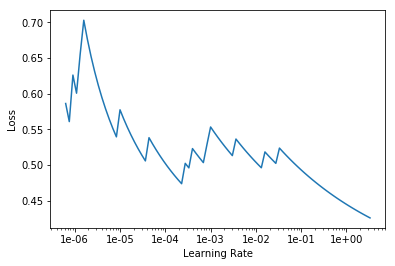

In [56]:
my_learner.lr_find()
my_learner.recorder.plot()


### Working model

In [ ]:
!gpustat

In [ ]:
def count_model_params(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

In [ ]:
batch_size = 1
my_data_bunch = DataBunch.create(train_ds,valid_ds,test_ds,bs=batch_size)
criterion = nn.CrossEntropyLoss() 

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels = 405, out_channels = 1, kernel_size = 1)

    def forward(self, x):
        input_size = x.shape[0]
        print("Input", x.shape)
        
        x = self.conv1(x)
        print("After conv:", x.shape)
        x = x.reshape(input_size, 5)
        print("\nEnd:", x.shape)
        print("End:", x)
        return x

print(net)  
print( 'trainable params: {}'.format(count_model_params(net)) )
net = Model().cuda()

my_learner = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion, metrics=accuracy_thresh)
my_learner.fit_one_cycle(1, 5e-02)


In [ ]:
my_learner.lr_find()
my_learner.recorder.plot()


In [ ]:
preds = my_learner.get_preds() #get valdation preds, 256
preds[0]

In [ ]:
np.where(preds[0] >= 0.5, 1, 0)

In [ ]:
my_learner.data.valid_ds[:][1]

In [ ]:
preds = my_learner.get_preds() #get valdation preds, 256
preds[0]

### Continued

In [ ]:
my_learner.save("Stage 0")

In [ ]:
my_learner.fit_one_cycle(5,5e-02)

In [ ]:
my_learner.save("Stage 1")

In [ ]:
my_learner.load("Stage 1")

In [ ]:
my_learner.lr_find()
my_learner.recorder.plot()


### NN test model

In [ ]:
def count_model_params(net):
    return sum(p.numel() for p in net.parameters() if p.requires_grad)

In [ ]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1*9, 5)
        self.maxpool = nn.MaxPool1d(kernel_size = 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return x

net = Net()
print(net)
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

input = torch.randn(1, 9)
input = my_data_bunch.train_ds[0][0]
out = net(input)
print(out.shape)
print(out)
print(input.shape)

In [ ]:
my_learner.fit_one_cycle(10,1e-1)


In [ ]:
batch_size = 1
my_data_bunch = DataBunch.create(train_ds,valid_ds,test_ds,bs=batch_size)

criterion = nn.CrossEntropyLoss() # NLL + Log_softmax layer = multi-class Cross-entropy

class Net(nn.Module):
    def __init__(self, input_size=(1*9), hidden_size=9, num_classes=1):
        super(Net, self).__init__()
        self.fc_0 = nn.Linear(input_size, hidden_size)
        self.relu_0 = nn.ReLU()
        self.fc_1 = nn.Linear(hidden_size,hidden_size)        
        self.relu_1 = nn.ReLU()
        self.last = nn.Linear(hidden_size,num_classes)
        self.log_softmax_layer = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.fc_0(x)
        out = self.relu_1(self.fc_0(out))
        out = self.last(out)
        print(out.shape)
        #out = self.log_softmax_layer(out)
        out = self.log_softmax_layer(out)
        #out = out.flatten()
        print(out.shape)
        print(out)
        return out
    
#create instance of model
net = Net(input_size=(1*9),hidden_size=9,num_classes=1).cuda()
print(net)  
print( 'trainable params: {}'.format(count_model_params(net)) )

my_learner = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion)
my_learner.fit_one_cycle(1,1e-1)

In [ ]:
my_learner.lr_find()
my_learner.recorder.plot()


In [ ]:
my_learner.fit_one_cycle(1,1e-1)

In [ ]:
out.flatten().shape

In [ ]:
my_data_bunch.train_ds[0][0].shape

In [ ]:
# pool of size=3, stride=2
m = nn.MaxPool1d(50, stride=1)
input = torch.randn(20, 16, 50)
output = m(input)
output

### 2.b Class definition of model

In [ ]:
y.shape

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size=(9), hidden_size=9, num_classes=3):
        super(Net, self).__init__()
        self.fc_0 = nn.Linear(input_size, hidden_size) 
        self.relu_0 = nn.ReLU()
        self.fc_1 = nn.Linear(hidden_size,hidden_size)        
        self.relu_1 = nn.ReLU()
        self.last = nn.Linear(hidden_size,num_classes)
        self.log_softmax_layer = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        out = self.relu_0(self.fc_0(x))
        out = self.relu_1(self.fc_1(out))
        out = self.log_softmax_layer(self.last(out))
        
        return out
    
#create instance of model
net = Net(input_size=(1),hidden_size=9,num_classes=3).cuda()
print(net)  
print( 'trainable params: {}'.format(count_model_params(net)) )

## 3. Build Learner

In [ ]:
my_learner = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion)

#### From here we can use the learner just like any other Fast.ai learner

In [ ]:
my_learner.lr_find()

In [ ]:
my_learner.recorder.plot()

In [ ]:
my_learner.fit_one_cycle(1,1e-1)

In [ ]:
plt.plot(my_learner.recorder.losses[::batch_size]) #losses for each batch.  Take at end of epoch only
plt.plot(my_learner.recorder.val_losses)

In [ ]:
X

In [ ]:
y